In [1]:
!git clone https://github.com/hansk88/Capstone-Project-ML.git

Cloning into 'Capstone-Project-ML'...
remote: Enumerating objects: 8002, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 8002 (delta 4), reused 1 (delta 1), pack-reused 7997 (from 1)
Receiving objects: 100% (8002/8002), 416.64 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (15209/15209), done.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from collections import Counter
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Untuk membagi data secara manual
import shutil # Untuk operasi file/folder

In [3]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [4]:
# Konfigurasi Dasar
DATA_DIR = '/content/Capstone-Project-ML/Dataset Makanan New'
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2
SEED = 42 # Untuk reproduktifitas hasil

In [5]:
# Persiapan Dataset
all_image_paths = []
all_labels = []
if not os.path.isdir(DATA_DIR):
    print(f"Error: Direktori '{DATA_DIR}' tidak ditemukan.")
    print("Pastikan folder ini ada dan berada di lokasi yang sama dengan skrip Anda.")
    exit()

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
num_classes = len(class_names)

if num_classes == 0:
    print(f"Error: Tidak ada sub-folder (kategori makanan) ditemukan di '{DATA_DIR}'.")
    print("Pastikan struktur folder Anda seperti 'Dataset Makanan/nasi_goreng/', 'Dataset Makanan/salad/', dll.")
    exit()

print(f"Ditemukan {num_classes} kategori: {class_names}")

label_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

if not all_image_paths:
    print(f"Error: Tidak ada gambar ditemukan di '{DATA_DIR}'. Pastikan gambar berada di dalam sub-folder kategori.")
    exit()

print(f"Total gambar yang ditemukan: {len(all_image_paths)}")

Ditemukan 35 kategori: ['Ayam Geprek (1 potong) = 394 kkal (62% lemak, 12% karb, 27% prot)', 'Ayam Pop (1 potong) = 170 kkal (46% lemak, 11% karb, 43% prot)', 'Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)', 'Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)', 'Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)', 'Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)', 'Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)', 'Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)', 'Dendeng (1 porsi) = 123 kkal (57% lemak, 11% karb, 33% prot)', 'Gorengan (1 potong) = 137 kkal (75% lemak, 19% karb, 6% prot)', 'Gulai Ikan (1 porsi) = 241 kkal (42% lemak, 8% karb, 50% prot)', 'Gulai Tambusu (1 porsi) = 204 kkal (39% lemak, 11% karb, 50% prot)', 'Gulai Tunjang (1 porsi) = 243 kkal (42% lemak, 12% karb, 46% prot)', 'Ikan Goreng (1 potong) = 192 kkal (23% lemak, 0% karb, 77% prot)', 'Ketoprak (1 porsi) = 402 kkal (34% lemak, 50

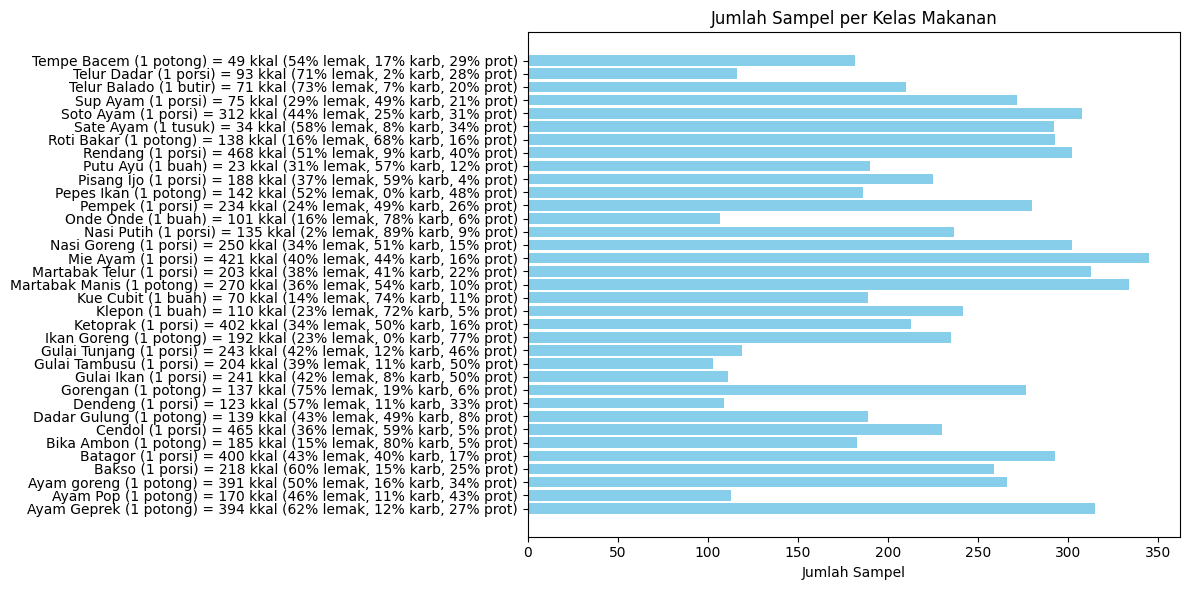

In [6]:
# Hitung jumlah sampel per label
label_counts = Counter(all_labels)

# Ambil nama label dan jumlahnya
labels = [class_names[i] for i in label_counts.keys()]
counts = [label_counts[i] for i in label_counts.keys()]

# Plot diagram batang
plt.figure(figsize=(12, 6))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Jumlah Sampel')
plt.title('Jumlah Sampel per Kelas Makanan')
plt.tight_layout()
plt.show()

In [7]:
# Augmentasi data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

MIN_PER_CLASS = 250

# Hitung jumlah gambar per kelas
class_counts = {label: 0 for label in label_to_index.values()}
for label in all_labels:
    class_counts[label] += 1

# Buat label ke nama folder
index_to_label = {v: k for k, v in label_to_index.items()}

# Loop tiap label
for label in class_counts:
    count = class_counts[label]
    if count >= MIN_PER_CLASS:
        continue  # skip kalau sudah cukup

    need = MIN_PER_CLASS - count
    class_name = index_to_label[label]
    class_paths = [p for p, l in zip(all_image_paths, all_labels) if l == label]

    print(f"Melakukan augmentasi {need} gambar untuk kelas '{class_name}'...")

    for i in range(need):
        src_path = random.choice(class_paths)
        img_raw = tf.io.read_file(src_path)
        img = tf.image.decode_image(img_raw, channels=3)
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32) / 255.0

        # Apply augmentasi
        aug = data_augmentation(tf.expand_dims(img, 0), training=True)
        aug = tf.squeeze(aug, 0).numpy()
        aug = (aug * 255).astype(np.uint8)

        # Simpan hasil
        filename = f"aug_{i}_{os.path.basename(src_path)}"
        save_path = os.path.join(DATA_DIR, class_name, filename)
        Image.fromarray(aug).save(save_path)

Melakukan augmentasi 137 gambar untuk kelas 'Ayam Pop (1 potong) = 170 kkal (46% lemak, 11% karb, 43% prot)'...
Melakukan augmentasi 67 gambar untuk kelas 'Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)'...
Melakukan augmentasi 20 gambar untuk kelas 'Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)'...
Melakukan augmentasi 61 gambar untuk kelas 'Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)'...
Melakukan augmentasi 141 gambar untuk kelas 'Dendeng (1 porsi) = 123 kkal (57% lemak, 11% karb, 33% prot)'...
Melakukan augmentasi 139 gambar untuk kelas 'Gulai Ikan (1 porsi) = 241 kkal (42% lemak, 8% karb, 50% prot)'...
Melakukan augmentasi 147 gambar untuk kelas 'Gulai Tambusu (1 porsi) = 204 kkal (39% lemak, 11% karb, 50% prot)'...
Melakukan augmentasi 131 gambar untuk kelas 'Gulai Tunjang (1 porsi) = 243 kkal (42% lemak, 12% karb, 46% prot)'...
Melakukan augmentasi 15 gambar untuk kelas 'Ikan Goreng (1 potong) = 192 kkal (23% lemak, 0% karb, 77

In [8]:
# Membaca ulang dataset setelah augmentasi
all_image_paths = []
all_labels = []
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            all_image_paths.append(os.path.join(class_dir, img_name))
            all_labels.append(label_to_index[class_name])

print(f"Total gambar setelah augmentasi: {len(all_image_paths)}")

Total gambar setelah augmentasi: 9451


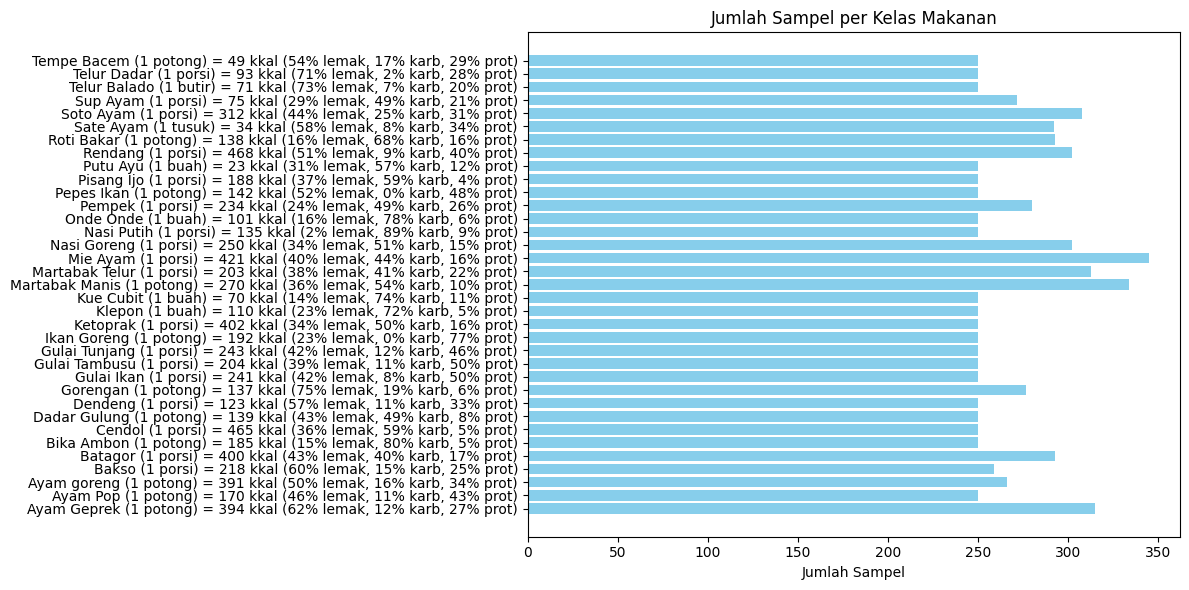

In [9]:
# Hitung ulang jumlah sampel per label setelah augmentasi
label_counts = Counter(all_labels)

# Ambil nama label dan jumlahnya
labels = [class_names[i] for i in label_counts.keys()]
counts = [label_counts[i] for i in label_counts.keys()]

# Plot diagram batang
plt.figure(figsize=(12, 6))
plt.barh(labels, counts, color='skyblue')
plt.xlabel('Jumlah Sampel')
plt.title('Jumlah Sampel per Kelas Makanan')
plt.tight_layout()
plt.show()

In [10]:
# Bagi data menjadi training dan validation set
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=all_labels
)

print(f"Jumlah gambar training: {len(train_paths)}")
print(f"Jumlah gambar validation: {len(val_labels)}")


Jumlah gambar training: 7560
Jumlah gambar validation: 1891


In [11]:
# Fungsi untuk memuat dan pra-proses gambar
def load_and_preprocess_image(image_path_tensor, label_tensor, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.io.read_file(image_path_tensor)
    img = tf.image.decode_jpeg(img, channels=3) # Sesuaikan jika ada PNG: tf.image.decode_image
    img = tf.image.resize(img, target_size)
    img = img / 255.0
    return img, label_tensor

In [12]:
# Membuat TensorFlow Dataset
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(train_paths), tf.constant(train_labels, dtype=tf.int32)))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((tf.constant(val_paths), tf.constant(val_labels, dtype=tf.int32)))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nDataset berhasil dibuat.")


Dataset berhasil dibuat.


In [13]:
# Membangun Model
print("Membangun model...")
base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                     include_top=False,
                                     weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()


Membangun model...


<ipython-input-13-f3bffa94a6ec>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,467 (9.26 MB)

 Trainable params: 168,483 (658.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Membuat fungsi callback
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

In [15]:
# Kompilasi model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("\nMemulai pelatihan model...")

# Melatih Model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

print("\nPelatihan selesai.")


Memulai pelatihan model...
Epoch 1/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 50s 38ms/step - accuracy: 0.3732 - loss: 2.3078 - val_accuracy: 0.7869 - val_loss: 0.7740
Epoch 2/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.7345 - loss: 0.8533 - val_accuracy: 0.8276 - val_loss: 0.6115
Epoch 3/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.8165 - loss: 0.6182 - val_accuracy: 0.8244 - val_loss: 0.5769
Epoch 4/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.8544 - loss: 0.4785 - val_accuracy: 0.8683 - val_loss: 0.4274
Epoch 5/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.8751 - loss: 0.3855 - val_accuracy: 0.8715 - val_loss: 0.4290
Epoch 6/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.9000 - loss: 0.3099 - val_accuracy: 0.8689 - val_loss: 0.4365
Epoch 7/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.9136 - loss: 0.2759 - val_accuracy: 0.8689 - val_loss: 0.4275
Epoch 8/50
945/945 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accura

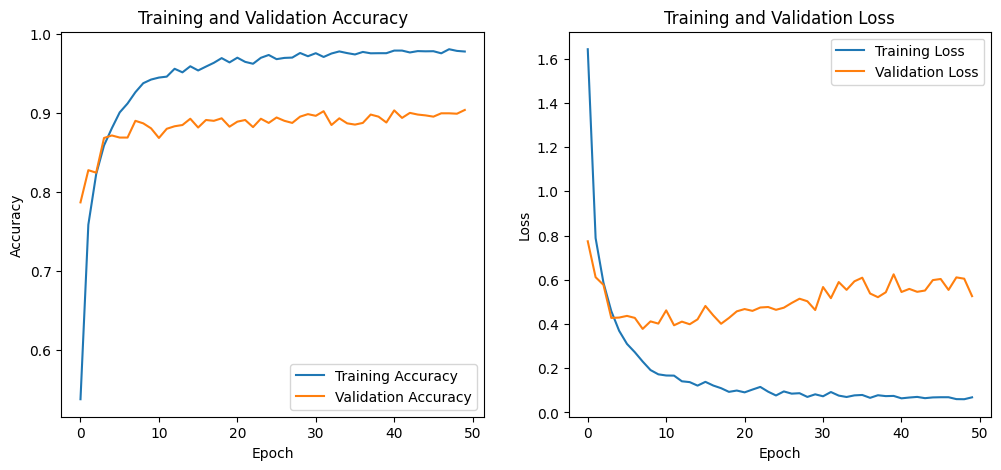

In [16]:
# Visualisasi Hasil Pelatihan
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
# Evaluasi Mendalam Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Untuk visualisasi confusion matrix
import matplotlib.image as mpimg

print("\n--- Evaluasi Mendalam Model ---")

# 1. Mengumpulkan Prediksi dan Label Sebenarnya dari Validation Set
y_true = []
y_pred_probs = [] # menyimpan probabilitas prediksi

for images, labels in val_ds.unbatch():
    y_true.append(labels.numpy())
    img_batch = tf.expand_dims(images, axis=0)
    y_pred_probs.append(model.predict(img_batch)[0])

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # mengambil ideks prob tertinggi



--- Evaluasi Mendalam Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━

In [18]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
                                                                      precision    recall  f1-score   support

   Ayam Geprek (1 potong) = 394 kkal (62% lemak, 12% karb, 27% prot)       0.83      0.92      0.87        63
      Ayam Pop (1 potong) = 170 kkal (46% lemak, 11% karb, 43% prot)       0.98      0.98      0.98        50
   Ayam goreng (1 potong) = 391 kkal (50% lemak, 16% karb, 34% prot)       0.92      0.83      0.87        53
          Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)       0.89      0.94      0.92        52
        Batagor (1 porsi) = 400 kkal (43% lemak, 40% karb, 17% prot)       0.85      0.90      0.88        59
     Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)       0.88      0.98      0.92        50
          Cendol (1 porsi) = 465 kkal (36% lemak, 59% karb, 5% prot)       0.96      0.90      0.93        50
   Dadar Gulung (1 potong) = 139 kkal (43% lemak, 49% karb, 8% prot)       0.98      0.94      


Membuat Confusion Matrix...


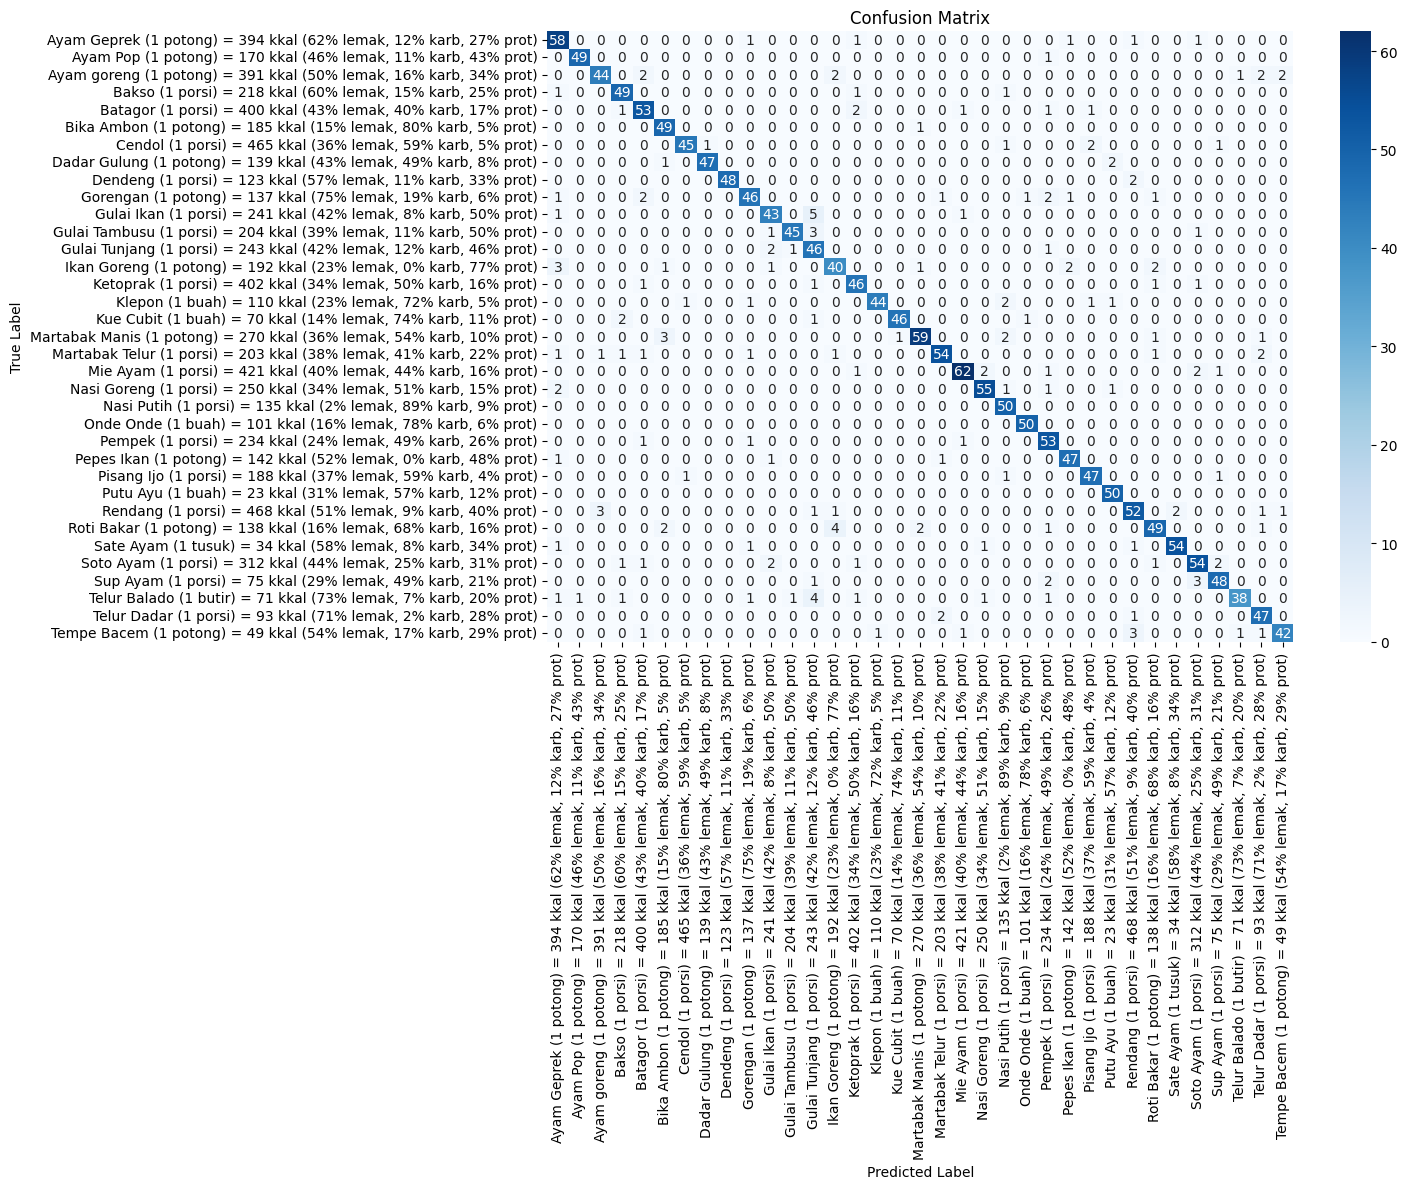

In [19]:
# Visualisasi Confusion Matrix
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



--- Analisis Contoh Kesalahan ---
Mencari contoh gambar yang salah diklasifikasikan...
Ditemukan 182 gambar yang salah diklasifikasikan.


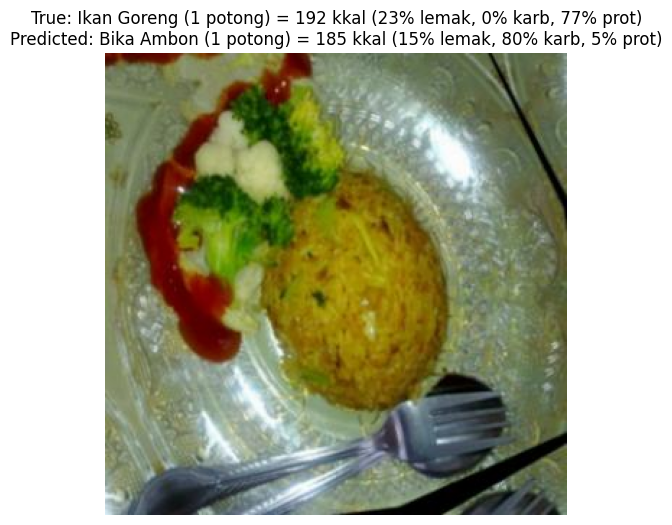

Gambar: /content/Capstone-Project-ML/Dataset Makanan New/Ikan Goreng (1 potong) = 192 kkal (23% lemak, 0% karb, 77% prot)/aug_3_ikan_goreng_137_jpg.rf.52e97af67eee6ad9e685fcf2a8dc15a2.jpg
True: Ikan Goreng (1 potong) = 192 kkal (23% lemak, 0% karb, 77% prot), Predicted: Bika Ambon (1 potong) = 185 kkal (15% lemak, 80% karb, 5% prot)



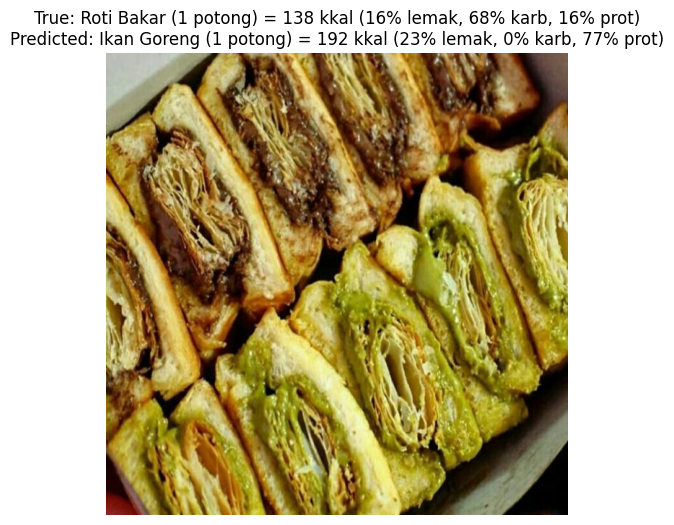

Gambar: /content/Capstone-Project-ML/Dataset Makanan New/Roti Bakar (1 potong) = 138 kkal (16% lemak, 68% karb, 16% prot)/roti_bakar_109_jpg.rf.d912216096549045373f475d65185ec4.jpg
True: Roti Bakar (1 potong) = 138 kkal (16% lemak, 68% karb, 16% prot), Predicted: Ikan Goreng (1 potong) = 192 kkal (23% lemak, 0% karb, 77% prot)



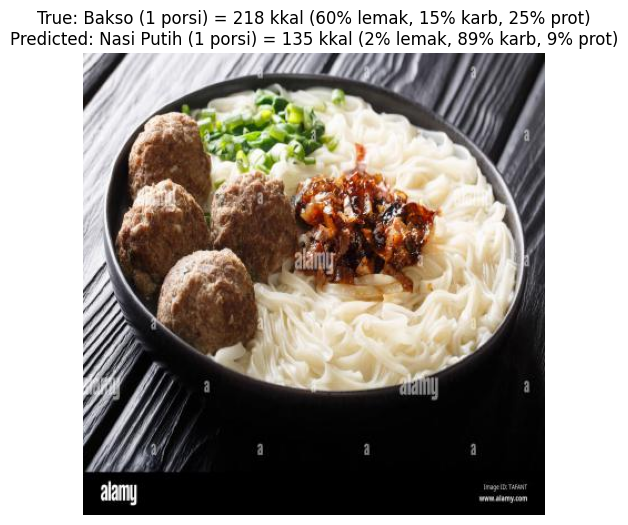

Gambar: /content/Capstone-Project-ML/Dataset Makanan New/Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot)/8_bakso_60_jpg.rf.5d303dbea961019fad47678024794e44.jpg
True: Bakso (1 porsi) = 218 kkal (60% lemak, 15% karb, 25% prot), Predicted: Nasi Putih (1 porsi) = 135 kkal (2% lemak, 89% karb, 9% prot)



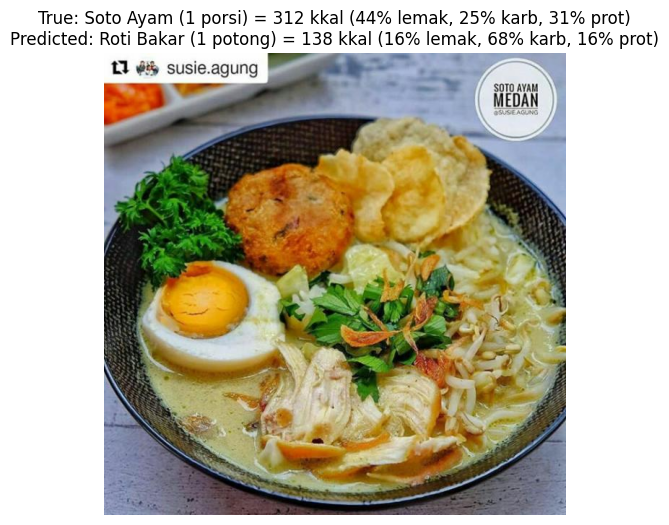

Gambar: /content/Capstone-Project-ML/Dataset Makanan New/Soto Ayam (1 porsi) = 312 kkal (44% lemak, 25% karb, 31% prot)/soto_ayam_141_jpg.rf.f0b83be724a48d7eb5d285158e2c8853.jpg
True: Soto Ayam (1 porsi) = 312 kkal (44% lemak, 25% karb, 31% prot), Predicted: Roti Bakar (1 potong) = 138 kkal (16% lemak, 68% karb, 16% prot)



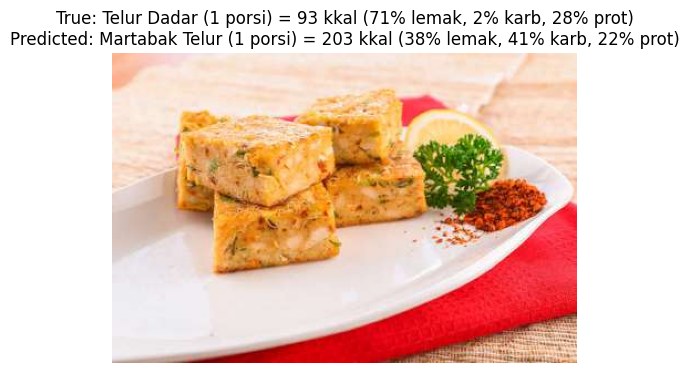

Gambar: /content/Capstone-Project-ML/Dataset Makanan New/Telur Dadar (1 porsi) = 93 kkal (71% lemak, 2% karb, 28% prot)/telur_dadar (114).jpg
True: Telur Dadar (1 porsi) = 93 kkal (71% lemak, 2% karb, 28% prot), Predicted: Martabak Telur (1 porsi) = 203 kkal (38% lemak, 41% karb, 22% prot)



In [20]:
# Analisis Contoh Kesalahan ML
print("\n--- Analisis Contoh Kesalahan ---")
print("Mencari contoh gambar yang salah diklasifikasikan...")

# Dapatkan indeks gambar yang salah diklasifikasikan
misclassified_indices = np.where(y_true != y_pred_classes)[0]

if len(misclassified_indices) > 0:
    print(f"Ditemukan {len(misclassified_indices)} gambar yang salah diklasifikasikan.")
    # Tampilkan beberapa contoh
    num_display_errors = min(5, len(misclassified_indices)) # Tampilkan maksimal 5 kesalahan

    error_paths = []
    error_true_labels = []
    error_predicted_labels = []

    for i in range(num_display_errors):
        idx_in_val_set = misclassified_indices[i]
        original_path = val_paths[idx_in_val_set]
        true_label = class_names[y_true[idx_in_val_set]]
        predicted_label = class_names[y_pred_classes[idx_in_val_set]]

        plt.figure(figsize=(6, 6))
        img = mpimg.imread(original_path)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')
        plt.show()
        print(f"Gambar: {original_path}\nTrue: {true_label}, Predicted: {predicted_label}\n")

else:
    print("Tidak ada gambar yang salah diklasifikasikan di validation set!")

In [21]:
# Menguji Model dan Melihat Persentase Keberhasilan
print(f"\nEvaluasi pada data validasi:")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Persentase Keberhasilan (Validation Accuracy): {val_accuracy*100:.2f}%")


Evaluasi pada data validasi:
237/237 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9030 - loss: 0.6007
Validation Loss: 0.5258
Persentase Keberhasilan (Validation Accuracy): 90.38%


In [22]:
# Menyimpan model dalam saved_model
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [23]:
# Menyimpan model dalam format h5
model.save('model.h5')

In [24]:
# Menyimpan model dalam tensoflow.js
!tensorflowjs_converter --input_format=tf_saved_model --saved_model_tags=serve saved_model tfjs_model

2025-06-05 15:20:34.743152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749136834.763879   24670 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749136834.770181   24670 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-05 15:20:44.767228: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749136844.767388   24670 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [27]:
# Menyimpan model dalam tensorflow lite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [28]:
# Download model yang telah disimpan dalam berbagai format
!zip -r saved_model_2.zip saved_model
!zip -r model.h5_2.zip model.h5
!zip -r tfjs_model_2.zip tfjs_model
!zip -r model.tflite_2.zip model.tflite

from google.colab import files
files.download('saved_model_2.zip')
files.download('model.h5_2.zip')
files.download('tfjs_model_2.zip')
files.download('model.tflite_2.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: model.h5 (deflated 11%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: model.tflite (deflated 82%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>